Deep Learning
=============

Chinese Word Embedding
------------

The goal is to train a Word2Vec skip-gram model over Chinese Wikipedia data.

In [1]:
# -*- coding: utf-8 -*-
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from matplotlib import font_manager
from six.moves import range
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE

#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

print(os.getcwd()) #print current working path
#print(os.listdir())

/content/datalab/udacity


Read the data into a string.
Build the dictionary and replace rare words with UNK token.
Function to generate a training batch for the skip-gram model.

In [3]:
vocabulary_size = 3000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

def maybe_pickle(target_data, set_filename, force=False):
  if os.path.exists(set_filename) and not force:
    if os.path.getsize(set_filename) > 0:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
      return set_filename
  print('Pickling %s.' % set_filename)
  try:
    with open(set_filename, 'wb') as f:
      pickle.dump(target_data, f, pickle.HIGHEST_PROTOCOL)
  except Exception as e:
    print('Unable to save data to', set_filename, ':', e)

#with open("wiki_cn_chunk.txt", 'r') as f:
def loadData(data_file="data.pickle", count_file="count.pickle", dict_file="dictionary.pickle", rev_dict_file="reverse_dictionary.pickle", force=False):
  if os.path.exists(data_file) and os.path.exists(count_file) and os.path.exists(dict_file) and os.path.exists(rev_dict_file) and not force:
    try:
      print("Pickle files found, try to load data from pickle files...")
      with open(data_file, 'rb') as f:
        data = pickle.load(f)
      with open(count_file, 'rb') as f:
        count = pickle.load(f)
      with open(dict_file, 'rb') as f:
        dictionary = pickle.load(f)
      with open(rev_dict_file, 'rb') as f:
        reverse_dictionary = pickle.load(f)
      print("Data loaded from pickle files successfully")
      print('Most common words (+UNK)', count[:5])
      print('Least common words', count[-10:])
      print('Sample data', data[:10])
      return data, count, dictionary, reverse_dictionary
    except Exception as e:
      print('Unable to load data', ':', e)
  with open("../notebooks/wiki_cn", 'r') as f:
    print("Loading words from text file...")
    #lines = tf.compat.as_str(f.read().decode("utf-8")).strip().split()
    lines = f.read().strip().decode("utf-8", "ignore").split()
    #print(lines[:10])
    words = []
    for line in lines:
        words.extend(list(line))
    print('Data size %d' % len(words))
    print(words[:10])
    
    print("Cooking data from words loaded...")
    data, count, dictionary, reverse_dictionary = build_dataset(words)
    print('Most common words (+UNK)', count[:5])
    print('Least common words', count[-10:])
    print('Sample data', data[:10])
    del words  # Hint to reduce memory.
    
    print("Saving cooked data into pickle files...")
    maybe_pickle(dictionary, "dictionary.pickle")
    maybe_pickle(reverse_dictionary, "reverse_dictionary.pickle")
    maybe_pickle(count, "count.pickle")
    maybe_pickle(data, "data.pickle")
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = loadData()

Pickle files found, try to load data from pickle files...
Data loaded from pickle files successfully
Most common words (+UNK) [['UNK', 1259386], (u'\uff0c', 5625618), (u'\u7684', 3907686), (u'\u3002', 3336048), (u'1', 2079419)]
Least common words [(u'\u9cc3', 1284), (u'\u5a04', 1282), (u'\u9a86', 1279), (u'\u8205', 1279), (u'\u6577', 1279), (u'\u8fed', 1276), (u'\u78fa', 1274), (u'\u6c50', 1271), (u'\u780d', 1271), (u'\u5d69', 1271)]
Sample data [178, 37, 230, 1225, 178, 37, 2, 507, 900, 56]


In [4]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

data: [u'\u6570', u'\u5b66', u'\u57fa', u'\u7840', u'\u6570', u'\u5b66', u'\u7684', u'\u77e5']

with num_skips = 2 and skip_window = 1:
    batch: [u'\u5b66', u'\u5b66', u'\u57fa', u'\u57fa', u'\u7840', u'\u7840', u'\u6570', u'\u6570', u'\u5b66', u'\u5b66', u'\u7684', u'\u7684', u'\u77e5', u'\u77e5', u'\u8bc6', u'\u8bc6']
    labels: [u'\u6570', u'\u57fa', u'\u7840', u'\u5b66', u'\u57fa', u'\u6570', u'\u5b66', u'\u7840', u'\u7684', u'\u6570', u'\u77e5', u'\u5b66', u'\u8bc6', u'\u7684', u'\u4e0e', u'\u77e5']

with num_skips = 4 and skip_window = 2:
    batch: [u'\u57fa', u'\u57fa', u'\u57fa', u'\u57fa', u'\u7840', u'\u7840', u'\u7840', u'\u7840', u'\u6570', u'\u6570', u'\u6570', u'\u6570', u'\u5b66', u'\u5b66', u'\u5b66', u'\u5b66']
    labels: [u'\u7840', u'\u6570', u'\u6570', u'\u5b66', u'\u5b66', u'\u57fa', u'\u6570', u'\u5b66', u'\u5b66', u'\u7684', u'\u57fa', u'\u7840', u'\u7840', u'\u7684', u'\u77e5', u'\u6570']


Train a skip-gram model.

In [5]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
num_skips = 4 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [6]:
#num_steps = 100001
num_steps = 5000001
#max_steps = len(data) * num_skips - 100

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.973995
Nearest to 由: 夹, 鳄, 妥, 虹, 蛇, 耐, 镰, 喀,
Nearest to 并: 厉, 劾, 擒, 姆, 首, 宛, 艳, 弦,
Nearest to 分: 翡, 卜, 北, 溃, v, 卿, 搜, 消,
Nearest to 第: 利, G, 紧, 的, 勤, 醉, 鹦, 霜,
Nearest to 和: 侄, 厥, 宦, 困, 看, 绳, 现, 赵,
Nearest to 会: 穆, 柬, 塞, 友, 念, 阳, 谷, 梁,
Nearest to 作: 真, 卵, 萍, 离, 沉, 专, 佳, 狂,
Nearest to 》: 士, 伯, 尽, 茂, 埔, 千, 岩, 恰,
Nearest to u: 程, 休, 氯, 津, 碟, 枫, 终, 仙,
Nearest to 7: 已, 下, 崖, 拓, 扰, 忌, 胃, 闵,
Nearest to 这: 矛, 漏, 沉, ト, 经, 亚, 】, R,
Nearest to 月: 就, 包, 将, 胚, 奸, 城, ‘, 渡,
Nearest to 本: 戎, 舒, 它, 贷, 砖, 腰, 厌, 诛,
Nearest to 尔: 贬, 柜, 碳, 锋, 棚, 堡, 蜜, 鞋,
Nearest to 后: 鼎, 截, 蜥, 添, 断, 疗, 激, 脏,
Nearest to 地: 烈, 庵, 酿, 宝, 叹, 煤, 庇, 熙,
Average loss at step 2000: 3.673785
Average loss at step 4000: 3.340825
Average loss at step 6000: 3.473507
Average loss at step 8000: 3.282796
Average loss at step 10000: 3.379157
Nearest to 由: 鳄, 妥, 忙, 微, 夹, 辩, 软, 双,
Nearest to 并: 擒, 厉, 昏, 设, 弦, 而, 末, 于,
Nearest to 分: 溃, 搜, 多, 尊, 烤, 蓝, 少, 曲,
Nearest to 第: 三, 醉, 霜, 潮, 套, 6, 勤, 夫,
Nearest to 和: 

In [7]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

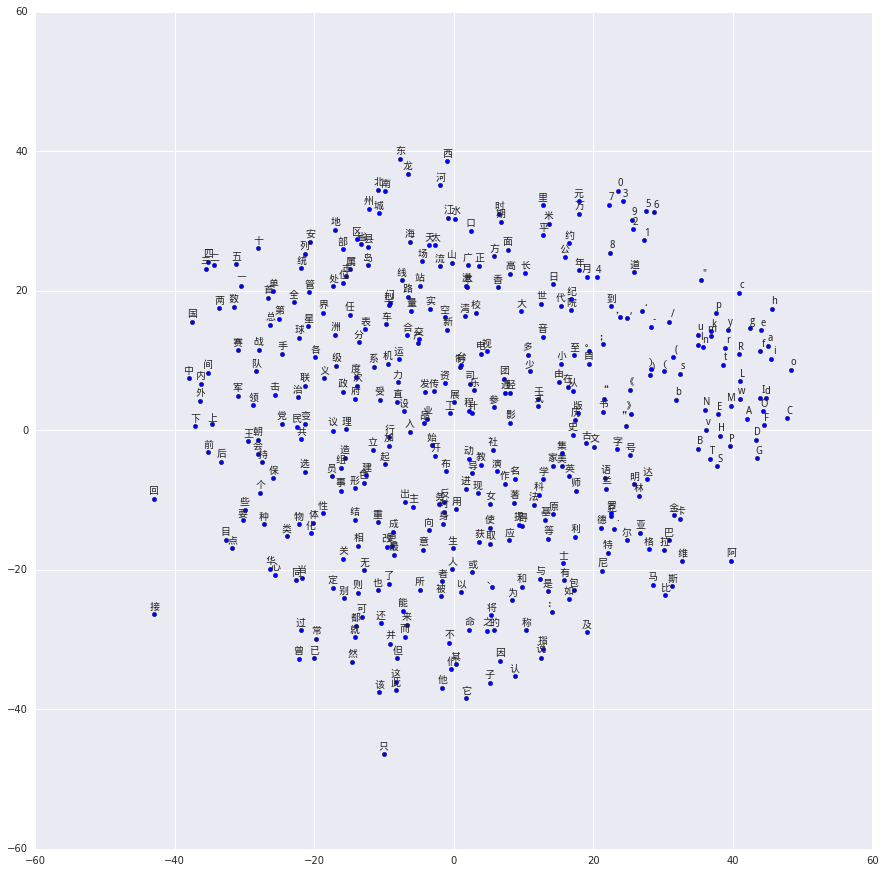

In [8]:
myfont = font_manager.FontProperties(fname='/content/datalab/notebooks/wqy-microhei/wqy-microhei.ttc')

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontproperties=myfont)
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [10]:
maybe_pickle(final_embeddings, "final_embeddings.pickle")
#maybe_pickle(final_embeddings, "final_embeddings_iter500W.pickle")

Pickling normalized_embeddings.pickle.
Unable to save data to normalized_embeddings.pickle : Can't pickle <type 'module'>: attribute lookup __builtin__.module failed
